# MPC


In [829]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Inintialize variables
dt = 0.1
start = 0 
stop = 10 
dummyDataX = np.arange(start ,stop ,dt)
dummyDataY = np.ones(len(dummyDataX))
dummyDataY = np.sin(dummyDataX)

class vehicleDynamicsJap:
    """
    Defining the vehicle dynamics, on unicycle model is assumed which is capable of instant acceleration
    """

    def __init__(self, dt):

        self.aC = np.array([
            [0, 1,0,0],
            [0.,0,0,0],
            [0.,0,0,1],
            [0.,0,0,0]])

        self.bC = np.array([
            [0],
            [1],
            [0],
            [1]])

        self.cC = np.array([
            [1, 0]])

        self.dC = np.array([
            [0.]])
        
    
        # Euler discretization
        self.A = np.eye(4) + self.aC * dt
        self.B = self.bC * dt
        self.C = self.cC
        self.D = self.dC

        
    def nextX(self, x, u):
        """
        Iterate over to the next x
        
        x -> current state  : np.array
        u -> input : np.array
        return -> next state : np.array
        """
        return self.A.dot(x) + self.B.dot(u.T).diagonal()
    
    
def mpcControl(vehicle, N, xInit, xTarget):
    """
    Control the vehicle using MPC it is assumed that the operater can only alter the acceleration
    
    vehicle -> model of the dynamics : object vehicleDynamicsJap
    N -> look ahead horizon : Int
    xInit -> current state : np.array
    xTarget -> desired state : np.array
    returns -> next input : list    
    """
    
    weightInput = np.array([[0,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])    # Weight on the input
    weightTracking = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # Weight on the tracking state
    
    cost = 0.
    constraints = []
    
    # Create the optimization variables
    x = cp.Variable((4, N + 1)) # cp.Variable((dim_1, dim_2))
    u = cp.Variable((4, N))
    
    constraints += [x[:, 0] == xInit]
        
    for k in range(N):
        # State space
        state_ = vehicle.A@x[:,k]
        input_ = u[:, k]
        
        # constraints
        constraints += [x[:, k+1] == state_ + input_]
        constraints += [u[0, k] == 0]
        constraints += [u[2, k] == 0]

        # Minimize the cost function
        cost += cp.quad_form(u[:, k], weightInput)
        cost += cp.quad_form((xTarget - x[:, k+1] ), weightTracking)


    
    # Solves the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.OSQP)

    # We return the MPC input and the next state (and also the plan for visualization)
    return u[:, 0].value, x[:, 1].value, x[:, :].value, None


def dummyRun():
    """
    Start simulating the run of the model and plot the results 
    
    input ->  None
    output-> Plots
    """

    lookahead = 10
    state_ = np.array([1,0,0,0])
    input_ = np.array([[0],[0],[0],[0]])
    vehicle = vehicleDynamicsJap(dt)
    target = np.zeros((4,4)) 

    # Saving data 
    TakingInputs = []
    NextState = []
    error = []
    desiredState = []

    for i in tqdm(range(len(dummyDataX))):

        # Get the next state
        state_ = vehicle.nextX(state_ , input_)

        # Reshaping data
        X = np.reshape(dummyDataX, (dummyDataX.shape[0], 1))
        velX = np.zeros(X.shape)
        Y = np.reshape(dummyDataY, (dummyDataY.shape[0], 1))
        velY = np.zeros(Y.shape)
        target = np.concatenate((X,velX,Y,velY), axis= 1)

        # Calculate control input
        input_   = mpcControl(vehicle, 10, state_, target[i,:])
        input_ = np.array(input_[0])
        input_ = np.reshape(input_, (input_.shape[0], 1))

        #Append to the lists
        TakingInputs.append(input_)
        NextState.append(state_)
        error.append(state_ - target[i,:] )
        desiredState.append(target[i,:])


    fig, axs = plt.subplots(2, figsize=(15, 15))
    fig.suptitle('MPC implementation vehicle dynamics')
    time = np.arange(0,len(np.array(NextState)[:,0]),1)
    axs[0].plot(np.array(NextState)[:,0],np.array(NextState)[:,2] , label = "Position robot")
    axs[0].plot(np.array(desiredState)[:,0],np.array(desiredState)[:,2] , label = "Desired Postion")

    axs[1].plot(np.array(NextState)[:,1],np.array(NextState)[:,3] , label = "Vel robot")
    axs[1].plot(np.array(desiredState)[:,1],np.array(desiredState)[:,3] , label = "Desired Vel")
    # axs[0].plot(target[:,0],target[:,1], label = "Desired position")
    # axs[1].plot(np.arange(0, len(sumErrorOverColumns),1),sumErrorOverColumns, label = "Error" )

    axs[0].legend()
    axs[1].legend()
    
    return


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.68it/s]


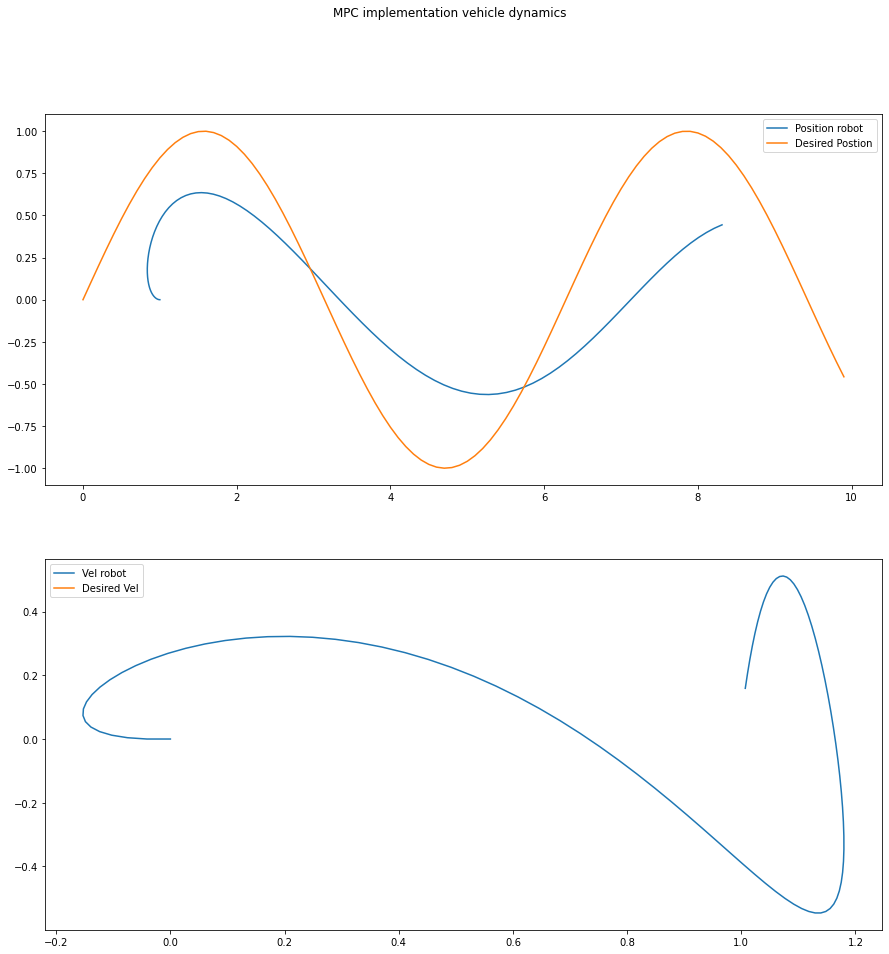

In [831]:
dummyRun()

In [636]:

class unicycle_dynamics:

    def __init__(self, dt):
        self.x = np.array([[0],[0],[0]], dtype = np.float64) 
        self.A_c = np.array([
            [1, 0, 0],
            [0 , 1, 0],
            [0,0, 1]], dtype= np.float64)

    def next_x(self, u):
        vx = np.cos(self.x[0])
        nextIteration = self.A_c.dot(u)
        
        # update 
        self.A_c = np.array([
            [np.cos(self.x[2][0]), 0, 0],
            [0 ,np.sin(self.x[2][0]), 0],
            [0,0, 1]])
        self.x = np.add( self.x, nextIteration*dt)  

        
        return self.x 
    
def mpc_control(vehicle, N, x_init, x_target, dt):
    # DO NOT CHANGE THESE PARAMETERS #
    weight_input = np.array([[1,0,0],[0,1,0],[0,0,1]])    # Weight on the input
    weight_tracking = np.array([[1,0,0],[0,1,0],[0,0,1]]) # Weight on the tracking state
    
    cost = 0.
    constraints = []
    
    # Create the optimization variables
    x = cp.Variable((3, N + 1)) # cp.Variable((dim_1, dim_2))
    u = cp.Variable((3, N))
    A_c = cp.Variable((3,3, N))    
    constraints += [x[:, 0] == x_init]
    
    for k in range(N):
        
        A_c = vehicle.A_c
        
        # do an iterative step
        state_ = A_c@u[:,k] * dt
        
        print(u[:,k])
        
        # constraints
        constraints += [x[:, k+1] == state_ +  x[:, k] ]
        constraints += [u[0, k] == u[1, k]]
        constraints += [A_c[0,0, k] == np.cos(x[:, k])]

        # Minimize the cost function
        cost += cp.quad_form(u[:, k], weight_input)
        cost += cp.quad_form((x_target - x[:, k+1] ), weight_tracking)


    
    # Solves the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.OSQP)

    # We return the MPC input and the next state (and also the plan for visualization)
    return u[:, 0].value, x[:, 1].value, x[:, :].value, None



lookahead = 10
state_ = np.array([[0],[0],[0]])
input_ = np.array([[0],[0],[0]])
vehicle = unicycle_dynamics(dt)
target = np.zeros((2,2)) 

# Saving data 
TakingInputs = []
NextState = []
error = []
desiredState = []

for i in tqdm(range(len(dummyDataX))):
    # Get the next state
    state_  = vehicle.next_x(input_)
    
    print(state_)
    
    # Reshaping data
    X = np.reshape(dummyDataX, (dummyDataX.shape[0], 1))
    Y = np.reshape(dummyDataY, (dummyDataY.shape[0], 1))
    th = np.reshape(np.zeros(dummyDataY.shape[0]), (dummyDataY.shape[0], 1))
    target = np.concatenate((X,Y,th), axis= 1)
    
    # Calculate control input
    input_   = mpc_control(vehicle, 10, state_.reshape(-1), target[i,:],dt)[0]
    input_ = np.array([[input_[0]],[input_[0]],[input_[2]]])

    #Append to the lists
    desiredState.append(target[i,:])
    TakingInputs.append(input_)
    NextState.append(state_)
    error.append(state_ - target[i,:] )

    

  1%|▊                                                                                 | 1/100 [00:00<00:17,  5.56it/s]

[[0.]
 [0.]
 [0.]]
var6255626[0:3, 0]
var6255626[0:3, 1]
var6255626[0:3, 2]
var6255626[0:3, 3]
var6255626[0:3, 4]
var6255626[0:3, 5]
var6255626[0:3, 6]
var6255626[0:3, 7]
var6255626[0:3, 8]
var6255626[0:3, 9]
[[0.]
 [0.]
 [0.]]
var6256325[0:3, 0]
var6256325[0:3, 1]
var6256325[0:3, 2]
var6256325[0:3, 3]
var6256325[0:3, 4]
var6256325[0:3, 5]
var6256325[0:3, 6]
var6256325[0:3, 7]


  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.23it/s]


var6256325[0:3, 8]
var6256325[0:3, 9]
[[0.00421136]
 [0.        ]
 [0.        ]]
var6257024[0:3, 0]
var6257024[0:3, 1]
var6257024[0:3, 2]
var6257024[0:3, 3]
var6257024[0:3, 4]
var6257024[0:3, 5]
var6257024[0:3, 6]
var6257024[0:3, 7]
var6257024[0:3, 8]
var6257024[0:3, 9]
[[0.01245672]
 [0.        ]
 [0.        ]]
var6257723[0:3, 0]
var6257723[0:3, 1]
var6257723[0:3, 2]
var6257723[0:3, 3]
var6257723[0:3, 4]
var6257723[0:3, 5]
var6257723[0:3, 6]
var6257723[0:3, 7]
var6257723[0:3, 8]
var6257723[0:3, 9]
[[0.02456619]
 [0.        ]
 [0.        ]]
var6258422[0:3, 0]
var6258422[0:3, 1]
var6258422[0:3, 2]
var6258422[0:3, 3]
var6258422[0:3, 4]
var6258422[0:3, 5]
var6258422[0:3, 6]
var6258422[0:3, 7]
var6258422[0:3, 8]
var6258422[0:3, 9]


  9%|███████▍                                                                          | 9/100 [00:00<00:05, 17.60it/s]

[[0.04037705]
 [0.        ]
 [0.        ]]
var6259121[0:3, 0]
var6259121[0:3, 1]
var6259121[0:3, 2]
var6259121[0:3, 3]
var6259121[0:3, 4]
var6259121[0:3, 5]
var6259121[0:3, 6]
var6259121[0:3, 7]
var6259121[0:3, 8]
var6259121[0:3, 9]
[[0.05973342]
 [0.        ]
 [0.        ]]
var6259820[0:3, 0]
var6259820[0:3, 1]
var6259820[0:3, 2]
var6259820[0:3, 3]
var6259820[0:3, 4]
var6259820[0:3, 5]
var6259820[0:3, 6]
var6259820[0:3, 7]
var6259820[0:3, 8]
var6259820[0:3, 9]
[[0.08248598]
 [0.        ]
 [0.        ]]
var6260519[0:3, 0]
var6260519[0:3, 1]
var6260519[0:3, 2]
var6260519[0:3, 3]
var6260519[0:3, 4]
var6260519[0:3, 5]
var6260519[0:3, 6]
var6260519[0:3, 7]
var6260519[0:3, 8]
var6260519[0:3, 9]
[[0.1084917]
 [0.       ]
 [0.       ]]
var6261218[0:3, 0]
var6261218[0:3, 1]
var6261218[0:3, 2]
var6261218[0:3, 3]
var6261218[0:3, 4]
var6261218[0:3, 5]
var6261218[0:3, 6]
var6261218[0:3, 7]
var6261218[0:3, 8]
var6261218[0:3, 9]



 11%|████████▉                                                                        | 11/100 [00:00<00:04, 18.26it/s]

[[0.13761359]
 [0.        ]
 [0.        ]]
var6261917[0:3, 0]
var6261917[0:3, 1]
var6261917[0:3, 2]
var6261917[0:3, 3]
var6261917[0:3, 4]
var6261917[0:3, 5]
var6261917[0:3, 6]
var6261917[0:3, 7]
var6261917[0:3, 8]
var6261917[0:3, 9]
[[0.16972041]
 [0.        ]
 [0.        ]]
var6262616[0:3, 0]
var6262616[0:3, 1]
var6262616[0:3, 2]
var6262616[0:3, 3]
var6262616[0:3, 4]
var6262616[0:3, 5]
var6262616[0:3, 6]
var6262616[0:3, 7]
var6262616[0:3, 8]
var6262616[0:3, 9]
[[0.20468645]
 [0.        ]
 [0.        ]]
var6263315[0:3, 0]
var6263315[0:3, 1]
var6263315[0:3, 2]
var6263315[0:3, 3]
var6263315[0:3, 4]
var6263315[0:3, 5]
var6263315[0:3, 6]
var6263315[0:3, 7]
var6263315[0:3, 8]
var6263315[0:3, 9]
[[0.24239131]
 [0.        ]
 [0.        ]]
var6264014[0:3, 0]
var6264014[0:3, 1]
var6264014[0:3, 2]
var6264014[0:3, 3]
var6264014[0:3, 4]
var6264014[0:3, 5]
var6264014[0:3, 6]
var6264014[0:3, 7]
var6264014[0:3, 8]
var6264014[0:3, 9]


 15%|████████████▏                                                                    | 15/100 [00:00<00:04, 17.71it/s]

[[0.28271964]
 [0.        ]
 [0.        ]]
var6264713[0:3, 0]
var6264713[0:3, 1]
var6264713[0:3, 2]
var6264713[0:3, 3]
var6264713[0:3, 4]
var6264713[0:3, 5]
var6264713[0:3, 6]
var6264713[0:3, 7]
var6264713[0:3, 8]
var6264713[0:3, 9]
[[0.32556095]
 [0.        ]
 [0.        ]]
var6265412[0:3, 0]
var6265412[0:3, 1]
var6265412[0:3, 2]
var6265412[0:3, 3]
var6265412[0:3, 4]
var6265412[0:3, 5]
var6265412[0:3, 6]
var6265412[0:3, 7]
var6265412[0:3, 8]
var6265412[0:3, 9]
[[0.37080942]
 [0.        ]
 [0.        ]]
var6266111[0:3, 0]
var6266111[0:3, 1]
var6266111[0:3, 2]
var6266111[0:3, 3]
var6266111[0:3, 4]
var6266111[0:3, 5]
var6266111[0:3, 6]
var6266111[0:3, 7]
var6266111[0:3, 8]
var6266111[0:3, 9]
[[0.41836368]
 [0.        ]
 [0.        ]]
var6266810[0:3, 0]
var6266810[0:3, 1]
var6266810[0:3, 2]
var6266810[0:3, 3]
var6266810[0:3, 4]
var6266810[0:3, 5]
var6266810[0:3, 6]
var6266810[0:3, 7]
var6266810[0:3, 8]
var6266810[0:3, 9]


 19%|███████████████▍                                                                 | 19/100 [00:01<00:04, 16.60it/s]

[[0.46812661]
 [0.        ]
 [0.        ]]
var6267509[0:3, 0]
var6267509[0:3, 1]
var6267509[0:3, 2]
var6267509[0:3, 3]
var6267509[0:3, 4]
var6267509[0:3, 5]
var6267509[0:3, 6]
var6267509[0:3, 7]
var6267509[0:3, 8]
var6267509[0:3, 9]
[[0.5200052]
 [0.       ]
 [0.       ]]
var6268208[0:3, 0]
var6268208[0:3, 1]
var6268208[0:3, 2]
var6268208[0:3, 3]
var6268208[0:3, 4]
var6268208[0:3, 5]
var6268208[0:3, 6]
var6268208[0:3, 7]
var6268208[0:3, 8]
var6268208[0:3, 9]
[[0.57391036]
 [0.        ]
 [0.        ]]
var6268907[0:3, 0]
var6268907[0:3, 1]
var6268907[0:3, 2]
var6268907[0:3, 3]
var6268907[0:3, 4]
var6268907[0:3, 5]
var6268907[0:3, 6]
var6268907[0:3, 7]
var6268907[0:3, 8]
var6268907[0:3, 9]
[[0.62975674]
 [0.        ]
 [0.        ]]
var6269606[0:3, 0]
var6269606[0:3, 1]
var6269606[0:3, 2]
var6269606[0:3, 3]
var6269606[0:3, 4]
var6269606[0:3, 5]

 23%|██████████████████▋                                                              | 23/100 [00:01<00:04, 17.05it/s]


var6269606[0:3, 6]
var6269606[0:3, 7]
var6269606[0:3, 8]
var6269606[0:3, 9]
[[0.68746258]
 [0.        ]
 [0.        ]]
var6270305[0:3, 0]
var6270305[0:3, 1]
var6270305[0:3, 2]
var6270305[0:3, 3]
var6270305[0:3, 4]
var6270305[0:3, 5]
var6270305[0:3, 6]
var6270305[0:3, 7]
var6270305[0:3, 8]
var6270305[0:3, 9]
[[0.74694959]
 [0.        ]
 [0.        ]]
var6271004[0:3, 0]
var6271004[0:3, 1]
var6271004[0:3, 2]
var6271004[0:3, 3]
var6271004[0:3, 4]
var6271004[0:3, 5]
var6271004[0:3, 6]
var6271004[0:3, 7]
var6271004[0:3, 8]
var6271004[0:3, 9]
[[0.80814274]
 [0.        ]
 [0.        ]]
var6271703[0:3, 0]
var6271703[0:3, 1]
var6271703[0:3, 2]
var6271703[0:3, 3]
var6271703[0:3, 4]
var6271703[0:3, 5]


 25%|████████████████████▎                                                            | 25/100 [00:01<00:04, 17.43it/s]


var6271703[0:3, 6]
var6271703[0:3, 7]
var6271703[0:3, 8]
var6271703[0:3, 9]
[[0.87097018]
 [0.        ]
 [0.        ]]
var6272402[0:3, 0]
var6272402[0:3, 1]
var6272402[0:3, 2]
var6272402[0:3, 3]
var6272402[0:3, 4]
var6272402[0:3, 5]
var6272402[0:3, 6]
var6272402[0:3, 7]
var6272402[0:3, 8]
var6272402[0:3, 9]
[[0.9353631]
 [0.       ]
 [0.       ]]
var6273101[0:3, 0]
var6273101[0:3, 1]
var6273101[0:3, 2]
var6273101[0:3, 3]
var6273101[0:3, 4]
var6273101[0:3, 5]
var6273101[0:3, 6]
var6273101[0:3, 7]
var6273101[0:3, 8]
var6273101[0:3, 9]
[[1.00125555]
 [0.        ]
 [0.        ]]
var6273800[0:3, 0]
var6273800[0:3, 1]
var6273800[0:3, 2]
var6273800[0:3, 3]
var6273800[0:3, 4]
var6273800[0:3, 5]
var6273800[0:3, 6]
var6273800[0:3, 7]
var6273800[0:3, 8]
var6273800[0:3, 9]


 29%|███████████████████████▍                                                         | 29/100 [00:01<00:03, 17.79it/s]

[[1.0685844]
 [0.       ]
 [0.       ]]
var6274499[0:3, 0]
var6274499[0:3, 1]
var6274499[0:3, 2]
var6274499[0:3, 3]
var6274499[0:3, 4]
var6274499[0:3, 5]
var6274499[0:3, 6]
var6274499[0:3, 7]
var6274499[0:3, 8]
var6274499[0:3, 9]
[[1.13728915]
 [0.        ]
 [0.        ]]
var6275198[0:3, 0]
var6275198[0:3, 1]
var6275198[0:3, 2]
var6275198[0:3, 3]
var6275198[0:3, 4]
var6275198[0:3, 5]
var6275198[0:3, 6]
var6275198[0:3, 7]
var6275198[0:3, 8]
var6275198[0:3, 9]
[[1.20731185]
 [0.        ]
 [0.        ]]
var6275897[0:3, 0]
var6275897[0:3, 1]
var6275897[0:3, 2]
var6275897[0:3, 3]
var6275897[0:3, 4]
var6275897[0:3, 5]
var6275897[0:3, 6]
var6275897[0:3, 7]
var6275897[0:3, 8]
var6275897[0:3, 9]
[[1.278597]
 [0.      ]
 [0.      ]]
var6276596[0:3, 0]
var6276596[0:3, 1]
var6276596[0:3, 2]
var6276596[0:3, 3]
var6276596[0:3, 4]
var6276596[0:3, 5]
var6276596[0:3, 6]
var6276596[0:3, 7]
var6276596[0:3, 8]
var6276596[0:3, 9]


 33%|██████████████████████████▋                                                      | 33/100 [00:01<00:03, 17.91it/s]

[[1.35109144]
 [0.        ]
 [0.        ]]
var6277295[0:3, 0]
var6277295[0:3, 1]
var6277295[0:3, 2]
var6277295[0:3, 3]
var6277295[0:3, 4]
var6277295[0:3, 5]
var6277295[0:3, 6]
var6277295[0:3, 7]
var6277295[0:3, 8]
var6277295[0:3, 9]
[[1.42474423]
 [0.        ]
 [0.        ]]
var6277994[0:3, 0]
var6277994[0:3, 1]
var6277994[0:3, 2]
var6277994[0:3, 3]
var6277994[0:3, 4]
var6277994[0:3, 5]
var6277994[0:3, 6]
var6277994[0:3, 7]
var6277994[0:3, 8]
var6277994[0:3, 9]
[[1.4995066]
 [0.       ]
 [0.       ]]
var6278693[0:3, 0]
var6278693[0:3, 1]
var6278693[0:3, 2]
var6278693[0:3, 3]
var6278693[0:3, 4]
var6278693[0:3, 5]
var6278693[0:3, 6]
var6278693[0:3, 7]
var6278693[0:3, 8]
var6278693[0:3, 9]
[[1.57533182]
 [0.        ]
 [0.        ]]
var6279392[0:3, 0]
var6279392[0:3, 1]
var6279392[0:3, 2]
var6279392[0:3, 3]
var6279392[0:3, 4]
var6279392[0:3, 5]
var6279392[0:3, 6]
var6279392[0:3, 7]
var6279392[0:3, 8]
var6279392[0:3, 9]


 37%|█████████████████████████████▉                                                   | 37/100 [00:02<00:03, 18.20it/s]

[[1.65217512]
 [0.        ]
 [0.        ]]
var6280091[0:3, 0]
var6280091[0:3, 1]
var6280091[0:3, 2]
var6280091[0:3, 3]
var6280091[0:3, 4]
var6280091[0:3, 5]
var6280091[0:3, 6]
var6280091[0:3, 7]
var6280091[0:3, 8]
var6280091[0:3, 9]
[[1.72999364]
 [0.        ]
 [0.        ]]
var6280790[0:3, 0]
var6280790[0:3, 1]
var6280790[0:3, 2]
var6280790[0:3, 3]
var6280790[0:3, 4]
var6280790[0:3, 5]
var6280790[0:3, 6]
var6280790[0:3, 7]
var6280790[0:3, 8]
var6280790[0:3, 9]
[[1.8087463]
 [0.       ]
 [0.       ]]
var6281489[0:3, 0]
var6281489[0:3, 1]
var6281489[0:3, 2]
var6281489[0:3, 3]
var6281489[0:3, 4]
var6281489[0:3, 5]
var6281489[0:3, 6]
var6281489[0:3, 7]
var6281489[0:3, 8]
var6281489[0:3, 9]
[[1.88839375]
 [0.        ]
 [0.        ]]
var6282188[0:3, 0]
var6282188[0:3, 1]
var6282188[0:3, 2]
var6282188[0:3, 3]
var6282188[0:3, 4]
var6282188[0:3, 5]
var6282188[0:3, 6]
var6282188[0:3, 7]
var6282188[0:3, 8]
var6282188[0:3, 9]


 41%|█████████████████████████████████▏                                               | 41/100 [00:02<00:03, 18.36it/s]

[[1.96889833]
 [0.        ]
 [0.        ]]
var6282887[0:3, 0]
var6282887[0:3, 1]
var6282887[0:3, 2]
var6282887[0:3, 3]
var6282887[0:3, 4]
var6282887[0:3, 5]
var6282887[0:3, 6]
var6282887[0:3, 7]
var6282887[0:3, 8]
var6282887[0:3, 9]
[[2.05022393]
 [0.        ]
 [0.        ]]
var6283586[0:3, 0]
var6283586[0:3, 1]
var6283586[0:3, 2]
var6283586[0:3, 3]
var6283586[0:3, 4]
var6283586[0:3, 5]
var6283586[0:3, 6]
var6283586[0:3, 7]
var6283586[0:3, 8]
var6283586[0:3, 9]
[[2.13233597]
 [0.        ]
 [0.        ]]
var6284285[0:3, 0]
var6284285[0:3, 1]
var6284285[0:3, 2]
var6284285[0:3, 3]
var6284285[0:3, 4]
var6284285[0:3, 5]
var6284285[0:3, 6]
var6284285[0:3, 7]
var6284285[0:3, 8]
var6284285[0:3, 9]
[[2.21520134]
 [0.        ]
 [0.        ]]
var6284984[0:3, 0]
var6284984[0:3, 1]
var6284984[0:3, 2]
var6284984[0:3, 3]
var6284984[0:3, 4]
var6284984[0:3, 5]
var6284984[0:3, 6]
var6284984[0:3, 7]
var6284984[0:3, 8]
var6284984[0:3, 9]


 46%|█████████████████████████████████████▎                                           | 46/100 [00:02<00:02, 19.19it/s]

[[2.29878831]
 [0.        ]
 [0.        ]]
var6285683[0:3, 0]
var6285683[0:3, 1]
var6285683[0:3, 2]
var6285683[0:3, 3]
var6285683[0:3, 4]
var6285683[0:3, 5]
var6285683[0:3, 6]
var6285683[0:3, 7]
var6285683[0:3, 8]
var6285683[0:3, 9]
[[2.3830665]
 [0.       ]
 [0.       ]]
var6286382[0:3, 0]
var6286382[0:3, 1]
var6286382[0:3, 2]
var6286382[0:3, 3]
var6286382[0:3, 4]
var6286382[0:3, 5]
var6286382[0:3, 6]
var6286382[0:3, 7]
var6286382[0:3, 8]
var6286382[0:3, 9]
[[2.46800678]
 [0.        ]
 [0.        ]]
var6287081[0:3, 0]
var6287081[0:3, 1]
var6287081[0:3, 2]
var6287081[0:3, 3]
var6287081[0:3, 4]
var6287081[0:3, 5]
var6287081[0:3, 6]
var6287081[0:3, 7]
var6287081[0:3, 8]
var6287081[0:3, 9]
[[2.55358128]
 [0.        ]
 [0.        ]]
var6287780[0:3, 0]
var6287780[0:3, 1]
var6287780[0:3, 2]
var6287780[0:3, 3]
var6287780[0:3, 4]
var6287780[0:3, 5]
var6287780[0:3, 6]
var6287780[0:3, 7]
var6287780[0:3, 8]
var6287780[0:3, 9]


 50%|████████████████████████████████████████▌                                        | 50/100 [00:02<00:02, 18.61it/s]

[[2.6397633]
 [0.       ]
 [0.       ]]
var6288479[0:3, 0]
var6288479[0:3, 1]
var6288479[0:3, 2]
var6288479[0:3, 3]
var6288479[0:3, 4]
var6288479[0:3, 5]
var6288479[0:3, 6]
var6288479[0:3, 7]
var6288479[0:3, 8]
var6288479[0:3, 9]
[[2.72652723]
 [0.        ]
 [0.        ]]
var6289178[0:3, 0]
var6289178[0:3, 1]
var6289178[0:3, 2]
var6289178[0:3, 3]
var6289178[0:3, 4]
var6289178[0:3, 5]
var6289178[0:3, 6]
var6289178[0:3, 7]
var6289178[0:3, 8]
var6289178[0:3, 9]
[[2.81384859]
 [0.        ]
 [0.        ]]
var6289877[0:3, 0]
var6289877[0:3, 1]
var6289877[0:3, 2]
var6289877[0:3, 3]
var6289877[0:3, 4]
var6289877[0:3, 5]
var6289877[0:3, 6]
var6289877[0:3, 7]
var6289877[0:3, 8]
var6289877[0:3, 9]
[[2.90170388]
 [0.        ]
 [0.        ]]
var6290576[0:3, 0]
var6290576[0:3, 1]
var6290576[0:3, 2]
var6290576[0:3, 3]
var6290576[0:3, 4]
var6290576[0:3, 5]
var6290576[0:3, 6]
var6290576[0:3, 7]
var6290576[0:3, 8]
var6290576[0:3, 9]
[[2.99007064]
 [0.        ]
 [0.        ]]
var6291275[0:3, 0]
var629127

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:03<00:02, 18.44it/s]


var6291275[0:3, 2]
var6291275[0:3, 3]
var6291275[0:3, 4]
var6291275[0:3, 5]
var6291275[0:3, 6]
var6291275[0:3, 7]
var6291275[0:3, 8]
var6291275[0:3, 9]
[[3.07892731]
 [0.        ]
 [0.        ]]
var6291974[0:3, 0]
var6291974[0:3, 1]
var6291974[0:3, 2]
var6291974[0:3, 3]
var6291974[0:3, 4]
var6291974[0:3, 5]
var6291974[0:3, 6]
var6291974[0:3, 7]
var6291974[0:3, 8]
var6291974[0:3, 9]
[[3.16825327]
 [0.        ]
 [0.        ]]
var6292673[0:3, 0]
var6292673[0:3, 1]
var6292673[0:3, 2]
var6292673[0:3, 3]
var6292673[0:3, 4]
var6292673[0:3, 5]
var6292673[0:3, 6]
var6292673[0:3, 7]
var6292673[0:3, 8]
var6292673[0:3, 9]
[[3.25802875]
 [0.        ]
 [0.        ]]
var6293372[0:3, 0]
var6293372[0:3, 1]
var6293372[0:3, 2]
var6293372[0:3, 3]
var6293372[0:3, 4]
var6293372[0:3, 5]
var6293372[0:3, 6]
var6293372[0:3, 7]
var6293372[0:3, 8]
var6293372[0:3, 9]
[[3.34823482]
 [0.        ]
 [0.        ]]
var6294071[0:3, 0]
var6294071[0:3, 1]

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:03<00:02, 18.59it/s]


var6294071[0:3, 2]
var6294071[0:3, 3]
var6294071[0:3, 4]
var6294071[0:3, 5]
var6294071[0:3, 6]
var6294071[0:3, 7]
var6294071[0:3, 8]
var6294071[0:3, 9]
[[3.43885335]
 [0.        ]
 [0.        ]]
var6294770[0:3, 0]
var6294770[0:3, 1]
var6294770[0:3, 2]
var6294770[0:3, 3]
var6294770[0:3, 4]
var6294770[0:3, 5]
var6294770[0:3, 6]
var6294770[0:3, 7]
var6294770[0:3, 8]
var6294770[0:3, 9]
[[3.52986696]
 [0.        ]
 [0.        ]]
var6295469[0:3, 0]
var6295469[0:3, 1]
var6295469[0:3, 2]
var6295469[0:3, 3]
var6295469[0:3, 4]
var6295469[0:3, 5]
var6295469[0:3, 6]
var6295469[0:3, 7]
var6295469[0:3, 8]
var6295469[0:3, 9]
[[3.62125903]
 [0.        ]
 [0.        ]]
var6296168[0:3, 0]
var6296168[0:3, 1]
var6296168[0:3, 2]
var6296168[0:3, 3]
var6296168[0:3, 4]
var6296168[0:3, 5]
var6296168[0:3, 6]
var6296168[0:3, 7]
var6296168[0:3, 8]
var6296168[0:3, 9]



 60%|████████████████████████████████████████████████▌                                | 60/100 [00:03<00:02, 18.43it/s]

[[3.7130136]
 [0.       ]
 [0.       ]]
var6296867[0:3, 0]
var6296867[0:3, 1]
var6296867[0:3, 2]
var6296867[0:3, 3]
var6296867[0:3, 4]
var6296867[0:3, 5]
var6296867[0:3, 6]
var6296867[0:3, 7]
var6296867[0:3, 8]
var6296867[0:3, 9]
[[3.80511542]
 [0.        ]
 [0.        ]]
var6297566[0:3, 0]
var6297566[0:3, 1]
var6297566[0:3, 2]
var6297566[0:3, 3]
var6297566[0:3, 4]
var6297566[0:3, 5]
var6297566[0:3, 6]
var6297566[0:3, 7]
var6297566[0:3, 8]
var6297566[0:3, 9]
[[3.89754986]
 [0.        ]
 [0.        ]]
var6298265[0:3, 0]
var6298265[0:3, 1]
var6298265[0:3, 2]
var6298265[0:3, 3]
var6298265[0:3, 4]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:03<00:02, 14.64it/s]

var6298265[0:3, 5]
var6298265[0:3, 6]
var6298265[0:3, 7]
var6298265[0:3, 8]
var6298265[0:3, 9]
[[3.99030292]
 [0.        ]
 [0.        ]]
var6298964[0:3, 0]
var6298964[0:3, 1]
var6298964[0:3, 2]
var6298964[0:3, 3]
var6298964[0:3, 4]
var6298964[0:3, 5]
var6298964[0:3, 6]
var6298964[0:3, 7]
var6298964[0:3, 8]
var6298964[0:3, 9]
[[4.08336116]
 [0.        ]
 [0.        ]]
var6299663[0:3, 0]
var6299663[0:3, 1]
var6299663[0:3, 2]
var6299663[0:3, 3]
var6299663[0:3, 4]
var6299663[0:3, 5]
var6299663[0:3, 6]
var6299663[0:3, 7]
var6299663[0:3, 8]
var6299663[0:3, 9]
[[4.17671175]
 [0.        ]
 [0.        ]]
var6300362[0:3, 0]
var6300362[0:3, 1]
var6300362[0:3, 2]
var6300362[0:3, 3]
var6300362[0:3, 4]
var6300362[0:3, 5]
var6300362[0:3, 6]
var6300362[0:3, 7]
var6300362[0:3, 8]
var6300362[0:3, 9]


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:03<00:01, 16.44it/s]

[[4.27034237]
 [0.        ]
 [0.        ]]
var6301061[0:3, 0]
var6301061[0:3, 1]
var6301061[0:3, 2]
var6301061[0:3, 3]
var6301061[0:3, 4]
var6301061[0:3, 5]
var6301061[0:3, 6]
var6301061[0:3, 7]
var6301061[0:3, 8]
var6301061[0:3, 9]
[[4.36424123]
 [0.        ]
 [0.        ]]
var6301760[0:3, 0]
var6301760[0:3, 1]
var6301760[0:3, 2]
var6301760[0:3, 3]
var6301760[0:3, 4]
var6301760[0:3, 5]
var6301760[0:3, 6]
var6301760[0:3, 7]
var6301760[0:3, 8]
var6301760[0:3, 9]
[[4.45839703]
 [0.        ]
 [0.        ]]
var6302459[0:3, 0]
var6302459[0:3, 1]
var6302459[0:3, 2]
var6302459[0:3, 3]
var6302459[0:3, 4]
var6302459[0:3, 5]
var6302459[0:3, 6]
var6302459[0:3, 7]
var6302459[0:3, 8]
var6302459[0:3, 9]
[[4.55279895]
 [0.        ]
 [0.        ]]
var6303158[0:3, 0]
var6303158[0:3, 1]
var6303158[0:3, 2]
var6303158[0:3, 3]
var6303158[0:3, 4]
var6303158[0:3, 5]
var6303158[0:3, 6]
var6303158[0:3, 7]
var6303158[0:3, 8]
var6303158[0:3, 9]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:04<00:01, 17.20it/s]

[[4.64743662]
 [0.        ]
 [0.        ]]
var6303857[0:3, 0]
var6303857[0:3, 1]
var6303857[0:3, 2]
var6303857[0:3, 3]
var6303857[0:3, 4]
var6303857[0:3, 5]
var6303857[0:3, 6]
var6303857[0:3, 7]
var6303857[0:3, 8]
var6303857[0:3, 9]
[[4.74230012]
 [0.        ]
 [0.        ]]
var6304556[0:3, 0]
var6304556[0:3, 1]
var6304556[0:3, 2]
var6304556[0:3, 3]
var6304556[0:3, 4]
var6304556[0:3, 5]
var6304556[0:3, 6]
var6304556[0:3, 7]
var6304556[0:3, 8]
var6304556[0:3, 9]
[[4.83737994]
 [0.        ]
 [0.        ]]
var6305255[0:3, 0]
var6305255[0:3, 1]
var6305255[0:3, 2]
var6305255[0:3, 3]
var6305255[0:3, 4]
var6305255[0:3, 5]
var6305255[0:3, 6]
var6305255[0:3, 7]
var6305255[0:3, 8]
var6305255[0:3, 9]
[[4.93266697]
 [0.        ]
 [0.        ]]
var6305954[0:3, 0]
var6305954[0:3, 1]
var6305954[0:3, 2]
var6305954[0:3, 3]
var6305954[0:3, 4]
var6305954[0:3, 5]
var6305954[0:3, 6]
var6305954[0:3, 7]
var6305954[0:3, 8]
var6305954[0:3, 9]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:04<00:01, 17.81it/s]

[[5.02815247]
 [0.        ]
 [0.        ]]
var6306653[0:3, 0]
var6306653[0:3, 1]
var6306653[0:3, 2]
var6306653[0:3, 3]
var6306653[0:3, 4]
var6306653[0:3, 5]
var6306653[0:3, 6]
var6306653[0:3, 7]
var6306653[0:3, 8]
var6306653[0:3, 9]
[[5.12382809]
 [0.        ]
 [0.        ]]
var6307352[0:3, 0]
var6307352[0:3, 1]
var6307352[0:3, 2]
var6307352[0:3, 3]
var6307352[0:3, 4]
var6307352[0:3, 5]
var6307352[0:3, 6]
var6307352[0:3, 7]
var6307352[0:3, 8]
var6307352[0:3, 9]
[[5.21968584]
 [0.        ]
 [0.        ]]
var6308051[0:3, 0]
var6308051[0:3, 1]
var6308051[0:3, 2]
var6308051[0:3, 3]
var6308051[0:3, 4]
var6308051[0:3, 5]
var6308051[0:3, 6]
var6308051[0:3, 7]
var6308051[0:3, 8]
var6308051[0:3, 9]
[[5.31571802]
 [0.        ]
 [0.        ]]
var6308750[0:3, 0]
var6308750[0:3, 1]
var6308750[0:3, 2]
var6308750[0:3, 3]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:04<00:01, 18.27it/s]


var6308750[0:3, 4]
var6308750[0:3, 5]
var6308750[0:3, 6]
var6308750[0:3, 7]
var6308750[0:3, 8]
var6308750[0:3, 9]
[[5.41191731]
 [0.        ]
 [0.        ]]
var6309449[0:3, 0]
var6309449[0:3, 1]
var6309449[0:3, 2]
var6309449[0:3, 3]
var6309449[0:3, 4]
var6309449[0:3, 5]
var6309449[0:3, 6]
var6309449[0:3, 7]
var6309449[0:3, 8]
var6309449[0:3, 9]
[[5.50827665]
 [0.        ]
 [0.        ]]
var6310148[0:3, 0]
var6310148[0:3, 1]
var6310148[0:3, 2]
var6310148[0:3, 3]
var6310148[0:3, 4]
var6310148[0:3, 5]
var6310148[0:3, 6]
var6310148[0:3, 7]
var6310148[0:3, 8]
var6310148[0:3, 9]
[[5.60478932]
 [0.        ]
 [0.        ]]
var6310847[0:3, 0]
var6310847[0:3, 1]
var6310847[0:3, 2]
var6310847[0:3, 3]
var6310847[0:3, 4]
var6310847[0:3, 5]
var6310847[0:3, 6]
var6310847[0:3, 7]
var6310847[0:3, 8]
var6310847[0:3, 9]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:04<00:01, 17.98it/s]

[[5.70144885]
 [0.        ]
 [0.        ]]
var6311546[0:3, 0]
var6311546[0:3, 1]
var6311546[0:3, 2]
var6311546[0:3, 3]
var6311546[0:3, 4]
var6311546[0:3, 5]
var6311546[0:3, 6]
var6311546[0:3, 7]
var6311546[0:3, 8]
var6311546[0:3, 9]
[[5.79824906]
 [0.        ]
 [0.        ]]
var6312245[0:3, 0]
var6312245[0:3, 1]
var6312245[0:3, 2]
var6312245[0:3, 3]
var6312245[0:3, 4]
var6312245[0:3, 5]
var6312245[0:3, 6]
var6312245[0:3, 7]
var6312245[0:3, 8]
var6312245[0:3, 9]
[[5.89518403]
 [0.        ]
 [0.        ]]
var6312944[0:3, 0]
var6312944[0:3, 1]
var6312944[0:3, 2]
var6312944[0:3, 3]
var6312944[0:3, 4]
var6312944[0:3, 5]
var6312944[0:3, 6]
var6312944[0:3, 7]
var6312944[0:3, 8]
var6312944[0:3, 9]
[[5.99224807]
 [0.        ]
 [0.        ]]
var6313643[0:3, 0]
var6313643[0:3, 1]
var6313643[0:3, 2]
var6313643[0:3, 3]
var6313643[0:3, 4]
var6313643[0:3, 5]
var6313643[0:3, 6]
var6313643[0:3, 7]
var6313643[0:3, 8]
var6313643[0:3, 9]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:05<00:00, 18.59it/s]

[[6.08943576]
 [0.        ]
 [0.        ]]
var6314342[0:3, 0]
var6314342[0:3, 1]
var6314342[0:3, 2]
var6314342[0:3, 3]
var6314342[0:3, 4]
var6314342[0:3, 5]
var6314342[0:3, 6]
var6314342[0:3, 7]
var6314342[0:3, 8]
var6314342[0:3, 9]
[[6.18674188]
 [0.        ]
 [0.        ]]
var6315041[0:3, 0]
var6315041[0:3, 1]
var6315041[0:3, 2]
var6315041[0:3, 3]
var6315041[0:3, 4]
var6315041[0:3, 5]
var6315041[0:3, 6]
var6315041[0:3, 7]
var6315041[0:3, 8]
var6315041[0:3, 9]
[[6.28416146]
 [0.        ]
 [0.        ]]
var6315740[0:3, 0]
var6315740[0:3, 1]
var6315740[0:3, 2]
var6315740[0:3, 3]
var6315740[0:3, 4]
var6315740[0:3, 5]
var6315740[0:3, 6]
var6315740[0:3, 7]
var6315740[0:3, 8]
var6315740[0:3, 9]
[[6.3816897]
 [0.       ]
 [0.       ]]
var6316439[0:3, 0]
var6316439[0:3, 1]
var6316439[0:3, 2]
var6316439[0:3, 3]
var6316439[0:3, 4]
var6316439[0:3, 5]
var6316439[0:3, 6]
var6316439[0:3, 7]
var6316439[0:3, 8]
var6316439[0:3, 9]



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:05<00:00, 18.59it/s]

[[6.47932204]
 [0.        ]
 [0.        ]]
var6317138[0:3, 0]
var6317138[0:3, 1]
var6317138[0:3, 2]
var6317138[0:3, 3]
var6317138[0:3, 4]
var6317138[0:3, 5]
var6317138[0:3, 6]
var6317138[0:3, 7]
var6317138[0:3, 8]
var6317138[0:3, 9]
[[6.57705409]
 [0.        ]
 [0.        ]]
var6317837[0:3, 0]
var6317837[0:3, 1]
var6317837[0:3, 2]
var6317837[0:3, 3]
var6317837[0:3, 4]
var6317837[0:3, 5]
var6317837[0:3, 6]
var6317837[0:3, 7]
var6317837[0:3, 8]
var6317837[0:3, 9]
[[6.67488165]
 [0.        ]
 [0.        ]]
var6318536[0:3, 0]
var6318536[0:3, 1]
var6318536[0:3, 2]
var6318536[0:3, 3]
var6318536[0:3, 4]
var6318536[0:3, 5]
var6318536[0:3, 6]
var6318536[0:3, 7]
var6318536[0:3, 8]
var6318536[0:3, 9]
[[6.7728007]
 [0.       ]
 [0.       ]]
var6319235[0:3, 0]
var6319235[0:3, 1]
var6319235[0:3, 2]
var6319235[0:3, 3]
var6319235[0:3, 4]
var6319235[0:3, 5]
var6319235[0:3, 6]
var6319235[0:3, 7]
var6319235[0:3, 8]
var6319235[0:3, 9]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:05<00:00, 19.79it/s]

[[6.87080739]
 [0.        ]
 [0.        ]]
var6319934[0:3, 0]
var6319934[0:3, 1]
var6319934[0:3, 2]
var6319934[0:3, 3]
var6319934[0:3, 4]
var6319934[0:3, 5]
var6319934[0:3, 6]
var6319934[0:3, 7]
var6319934[0:3, 8]
var6319934[0:3, 9]
[[6.96889802]
 [0.        ]
 [0.        ]]
var6320633[0:3, 0]
var6320633[0:3, 1]
var6320633[0:3, 2]
var6320633[0:3, 3]
var6320633[0:3, 4]
var6320633[0:3, 5]
var6320633[0:3, 6]
var6320633[0:3, 7]
var6320633[0:3, 8]
var6320633[0:3, 9]
[[7.06706906]
 [0.        ]
 [0.        ]]
var6321332[0:3, 0]
var6321332[0:3, 1]
var6321332[0:3, 2]
var6321332[0:3, 3]
var6321332[0:3, 4]
var6321332[0:3, 5]
var6321332[0:3, 6]
var6321332[0:3, 7]
var6321332[0:3, 8]
var6321332[0:3, 9]
[[7.16531713]
 [0.        ]
 [0.        ]]
var6322031[0:3, 0]
var6322031[0:3, 1]
var6322031[0:3, 2]
var6322031[0:3, 3]
var6322031[0:3, 4]
var6322031[0:3, 5]
var6322031[0:3, 6]
var6322031[0:3, 7]
var6322031[0:3, 8]
var6322031[0:3, 9]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.38it/s]

[[7.26363897]
 [0.        ]
 [0.        ]]
var6322730[0:3, 0]
var6322730[0:3, 1]
var6322730[0:3, 2]
var6322730[0:3, 3]
var6322730[0:3, 4]
var6322730[0:3, 5]
var6322730[0:3, 6]
var6322730[0:3, 7]
var6322730[0:3, 8]
var6322730[0:3, 9]
[[7.36203149]
 [0.        ]
 [0.        ]]
var6323429[0:3, 0]
var6323429[0:3, 1]
var6323429[0:3, 2]
var6323429[0:3, 3]
var6323429[0:3, 4]
var6323429[0:3, 5]
var6323429[0:3, 6]
var6323429[0:3, 7]
var6323429[0:3, 8]
var6323429[0:3, 9]
[[7.46049171]
 [0.        ]
 [0.        ]]
var6324128[0:3, 0]
var6324128[0:3, 1]
var6324128[0:3, 2]
var6324128[0:3, 3]
var6324128[0:3, 4]
var6324128[0:3, 5]
var6324128[0:3, 6]
var6324128[0:3, 7]
var6324128[0:3, 8]
var6324128[0:3, 9]
[[7.55901677]
 [0.        ]
 [0.        ]]
var6324827[0:3, 0]
var6324827[0:3, 1]
var6324827[0:3, 2]
var6324827[0:3, 3]
var6324827[0:3, 4]
var6324827[0:3, 5]
var6324827[0:3, 6]
var6324827[0:3, 7]
var6324827[0:3, 8]
var6324827[0:3, 9]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.65it/s]


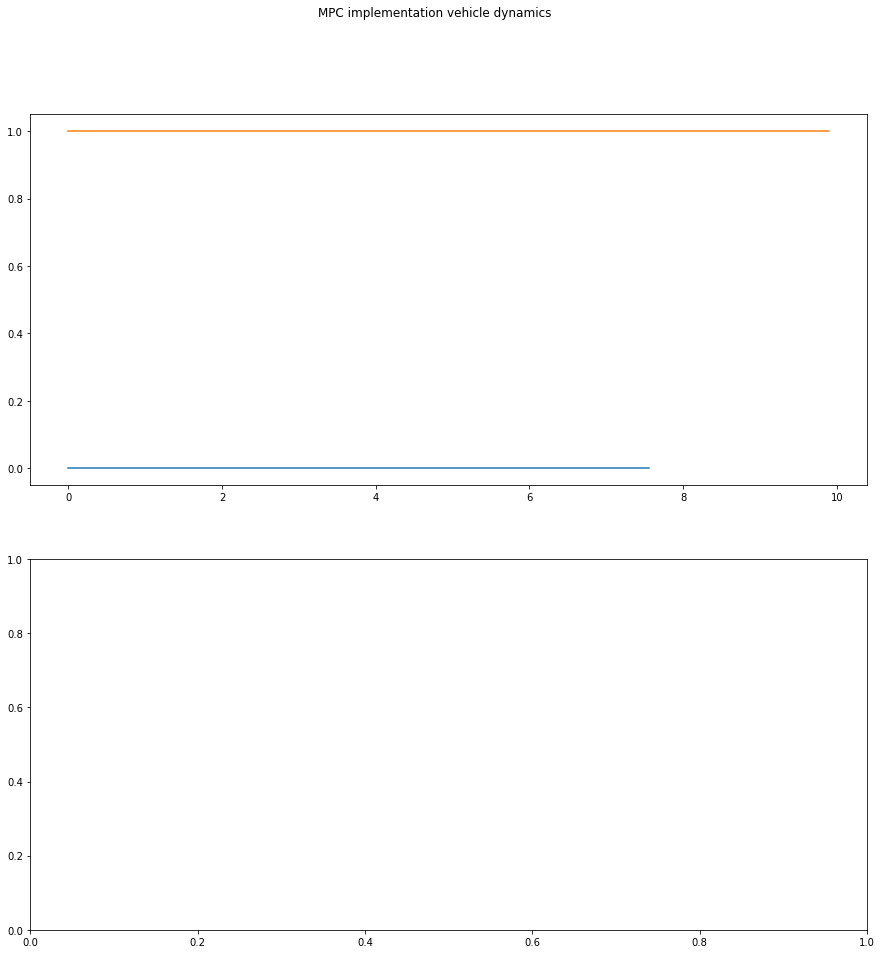

In [635]:
#sumErrorOverColumns = np.sum(error, axis=1)
fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle('MPC implementation vehicle dynamics')
axs[0].plot(np.array(NextState)[:,0],np.array(NextState)[:,1] , label = "Position robot")
axs[0].plot(target[:,0],target[:,1], label = "Desired position")
# axs[1].plot(np.arange(0, len(sumErrorOverColumns),1),sumErrorOverColumns, label = "Error" )

# axs[0].legend()
# axs[1].legend()


In [611]:
A_c = np.array([
    [np.cos( state_[2] ), 0, 0],
    [0 , np.sin( state_[2]  ), 0],
    [0,0, 1]], dtype = np.float64)

print(A_c[:])

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


[[0.1]
 [0. ]
 [0.1]]
[[0.2]
 [0. ]
 [0.2]]
[[0.29950042]
 [0.00998334]
 [0.3       ]]
[[0.39750707]
 [0.02985027]
 [0.4       ]]
[[0.49304072]
 [0.0594023 ]
 [0.5       ]]
[[0.58514682]
 [0.09834413]
 [0.6       ]]
[[0.67290508]
 [0.14628668]
 [0.7       ]]
[[0.75543864]
 [0.20275093]
 [0.8       ]]
[[0.83192286]
 [0.2671727 ]
 [0.9       ]]
[[0.90159353]
 [0.33890831]
 [1.        ]]


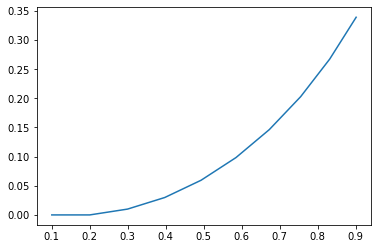

In [628]:
# Saving data 
TakingInputs = []
NextState = []
error = []
desiredState = []
vehicle = unicycle_dynamics(dt)

for i in range(10):
    input_ = np.array([[1],[1],[1]], dtype = np.float64) 
    state_ = vehicle.next_x(input_)
    last = vehicle.A_c
    NextState.append(state_)
    
    print(state_)

plt.plot(np.array(NextState)[:,0],np.array(NextState)[:,1])

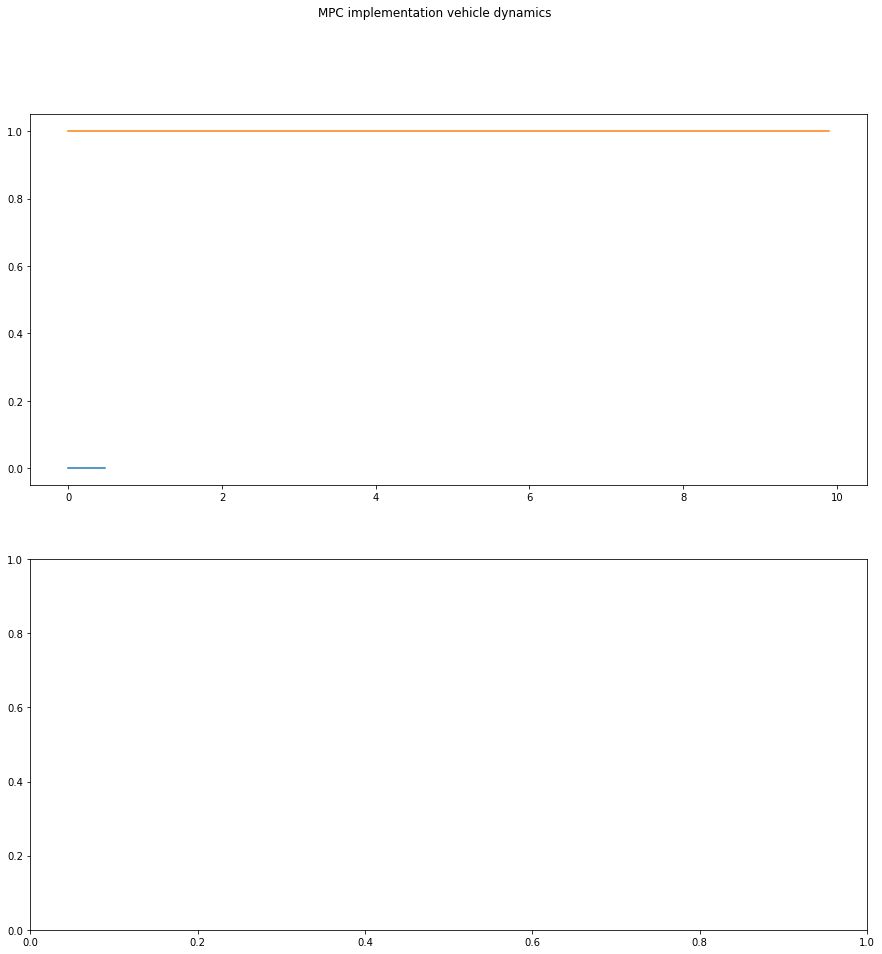

In [681]:
from tqdm import tqdm

class vehicle_dynamics:

    def __init__(self, dt):

        self.A_c = np.array([
            [0, 1],
            [0., 0]])

        self.B_c = np.array([
            [0],
            [1]])

        self.C_c = np.array([
            [1, 0]])

        self.D_c = np.array([
            [0.]])
        
    
        # Euler discretization
        self.A = np.eye(2) + self.A_c * dt
        self.B = self.B_c * dt
        self.C = self.C_c
        self.D = self.D_c

        # Limits on state and input
        self.x_min = np.array([-1., -10])
        self.x_max = np.array([100, 25])
        self.u_min = -4.0
        self.u_max = 4.0
        
        # Used later
        self.theta_min = 0
        self.theta_max = 0
        
    def next_x(self, x, u):
        return self.A.dot(x) + self.B.transpose().dot(u)
    
    
def mpc_control(vehicle, N, x_init, x_target):
    # DO NOT CHANGE THESE PARAMETERS #
    weight_input = 0.2*np.eye(1)    # Weight on the input
    weight_tracking = np.array([[1,0],[0,0]]) # Weight on the tracking state
    
    cost = 0.
    constraints = []
    
    # Create the optimization variables
    x = cp.Variable((2, N + 1)) # cp.Variable((dim_1, dim_2))
    u = cp.Variable((1, N))
    
    constraints += [x[:, 0] == x_init]
        
    for k in range(N):
        # State space
        state_ = vehicle.A@x[:,k]
        input_ = vehicle.B@u[:, k]
        
        # constraints
        constraints += [x[:, k+1] == state_ + input_]

        # Minimize the cost function
        cost += cp.quad_form(u[:, k], weight_input)
        cost += cp.quad_form((x_target - x[:, k+1] ), weight_tracking)


    
    # Solves the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver=cp.OSQP)

    # We return the MPC input and the next state (and also the plan for visualization)
    return u[:, 0].value, x[:, 1].value, x[:, :].value, None



lookahead = 10
state_ = np.array([0,0])
input_ = np.array([0,0])
vehicle = vehicle_dynamics(dt)
target = np.zeros((2,2)) 

# Saving data 
TakingInputs = []
NextState = []
error = []
desiredState = []

for i in tqdm(range(len(dummyDataX))):
    
    # Get the next state
    state_ = vehicle.next_x(state_ , input_)
    
    # Reshaping data
    X = np.reshape(dummyDataX, (dummyDataX.shape[0], 1))
    Y = np.reshape(dummyDataY, (dummyDataY.shape[0], 1))
    target = np.concatenate((X,Y), axis= 1)
    
    # Calculate control input
    input_   = mpc_control(vehicle, 10, state_, target[i,:])
    
    # Adding zero to the end to be compliant
    input_ = np.pad(input_[0], (0, 1), 'constant')

    #Append to the lists
    TakingInputs.append(input_)
    NextState.append(state_)
    error.append(state_ - target[i,:] )
    desiredState.append(target[i,:])



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.08it/s]


In [682]:
# Saving data 
state_ = np.array([0,0])
input_ = np.array([0,1])
TakingInputs = []
NextState = []
error = []
desiredState = []
vehicle = vehicle_dynamics(dt)
for i in range(1000):
    state_ = vehicle.next_x(state_ , input_)
    NextState.append(state_)
    
    

In [683]:
np.array(NextState)[:,0]

array([1.00000e-01, 2.10000e-01, 3.30000e-01, 4.60000e-01, 6.00000e-01,
       7.50000e-01, 9.10000e-01, 1.08000e+00, 1.26000e+00, 1.45000e+00,
       1.65000e+00, 1.86000e+00, 2.08000e+00, 2.31000e+00, 2.55000e+00,
       2.80000e+00, 3.06000e+00, 3.33000e+00, 3.61000e+00, 3.90000e+00,
       4.20000e+00, 4.51000e+00, 4.83000e+00, 5.16000e+00, 5.50000e+00,
       5.85000e+00, 6.21000e+00, 6.58000e+00, 6.96000e+00, 7.35000e+00,
       7.75000e+00, 8.16000e+00, 8.58000e+00, 9.01000e+00, 9.45000e+00,
       9.90000e+00, 1.03600e+01, 1.08300e+01, 1.13100e+01, 1.18000e+01,
       1.23000e+01, 1.28100e+01, 1.33300e+01, 1.38600e+01, 1.44000e+01,
       1.49500e+01, 1.55100e+01, 1.60800e+01, 1.66600e+01, 1.72500e+01,
       1.78500e+01, 1.84600e+01, 1.90800e+01, 1.97100e+01, 2.03500e+01,
       2.10000e+01, 2.16600e+01, 2.23300e+01, 2.30100e+01, 2.37000e+01,
       2.44000e+01, 2.51100e+01, 2.58300e+01, 2.65600e+01, 2.73000e+01,
       2.80500e+01, 2.88100e+01, 2.95800e+01, 3.03600e+01, 3.115

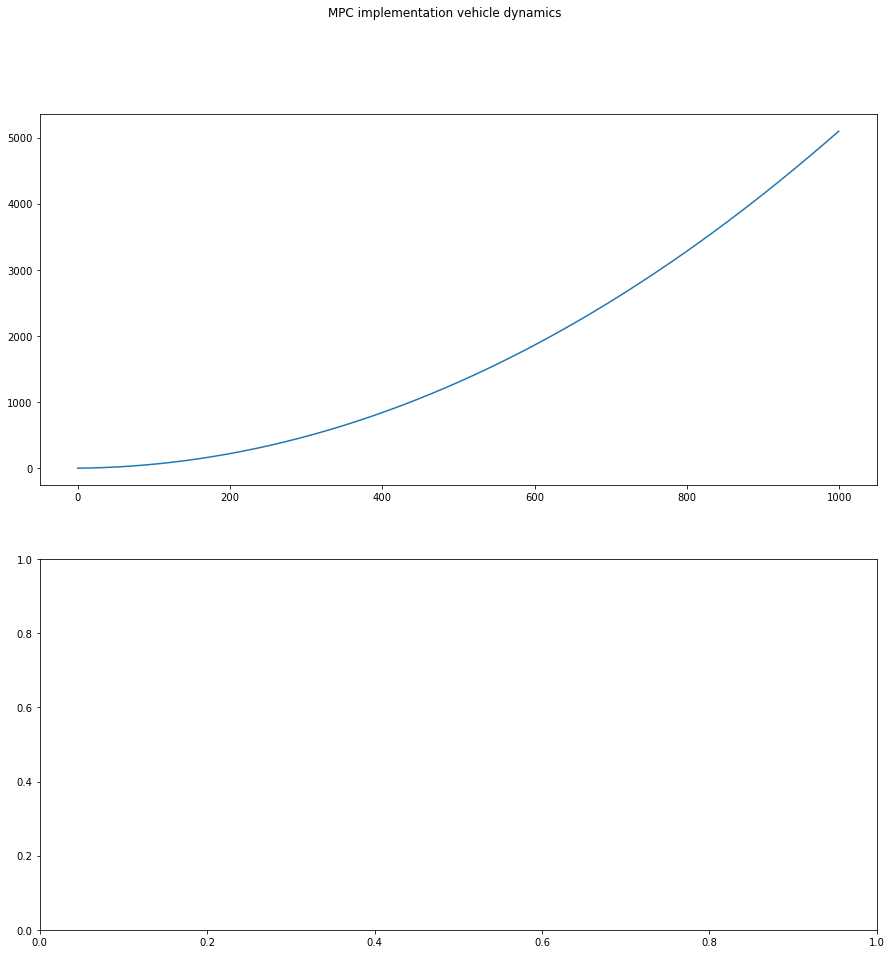

In [685]:

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle('MPC implementation vehicle dynamics')
time = np.arange(0,len(np.array(NextState)[:,0]),1)
axs[0].plot(time, np.array(NextState)[:,0] , label = "Position robot")
# axs[0].plot(target[:,0],target[:,1], label = "Desired position")
# axs[1].plot(np.arange(0, len(sumErrorOverColumns),1),sumErrorOverColumns, label = "Error" )

# axs[0].legend()
# axs[1].legend()
